In [1]:
# Packages / libraries
import os #provides functions for interacting with the operating system
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import sys
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


# remove warnings
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pandas.io.formats.format')

# 1. Loading Dataset

In [2]:
# Loading the data
new_data = pd.read_csv("/kaggle/input/seperated-data/India_Lucknow.csv")

# print the shape
print(new_data.shape)

#runs the first 5 rows
new_data.head()

(2297, 12)


,Date,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
0,2014-12-29,18.9,0.8,NaN,177.0,NaN,3.3,NaN,NaN,NaN,NaN,India_Lucknow
1,2014-12-30,18.5,0.7,NaN,258.0,NaN,3.2,NaN,NaN,NaN,NaN,India_Lucknow
2,2014-12-31,0.2,2.3,NaN,58.0,NaN,3.2,NaN,NaN,NaN,NaN,India_Lucknow
3,2015-01-01,18.5,1.0,NaN,188.0,NaN,3.5,NaN,NaN,NaN,NaN,India_Lucknow
4,2015-01-02,18.5,1.2,NaN,140.0,NaN,3.6,NaN,NaN,NaN,NaN,India_Lucknow


In [3]:
# Find the minimum and maximum dates
min_date = new_data['Date'].min()
max_date = new_data['Date'].max()

print('Minimum date:', min_date)
print('Maximum date:', max_date)

Minimum date: 2014-12-29
Maximum date: 2023-10-01


In [4]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2297 non-null   object 
 1   co            2294 non-null   float64
 2   no2           2297 non-null   float64
 3   o3            2243 non-null   float64
 4   pm10          1151 non-null   float64
 5   pm25          2231 non-null   float64
 6   so2           2291 non-null   float64
 7   humidity      1672 non-null   float64
 8   pressure      1672 non-null   float64
 9   temperature   1671 non-null   float64
 10  wind-speed    1603 non-null   float64
 11  Country_City  2297 non-null   object 
dtypes: float64(10), object(2)
memory usage: 215.5+ KB


In [5]:
new_data.describe()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed
count,2294.000000,2297.000000,2243.000000,1151.000000,2231.000000,2291.000000,1672.000000,1672.000000,1671.000000,1603.000000
mean,9.589974,13.868829,13.235533,96.384883,152.608696,3.795199,63.791567,939.753170,26.178276,0.550655
std,3.128279,7.460949,7.828471,56.502162,56.077578,1.413211,21.900501,185.198185,6.204938,0.291523
min,0.100000,0.400000,1.600000,13.000000,29.000000,0.900000,0.000000,0.000000,7.000000,0.000000
25%,7.800000,7.900000,8.000000,56.000000,109.000000,2.800000,48.875000,991.375000,21.900000,0.400000
50%,9.300000,12.700000,11.400000,86.000000,161.000000,3.700000,67.000000,1002.000000,28.000000,0.500000
75%,10.600000,18.200000,16.300000,122.000000,181.000000,4.500000,81.200000,1009.700000,31.000000,0.600000
max,42.000000,48.100000,62.600000,591.000000,420.000000,9.900000,97.500000,1023.000000,36.700000,4.100000


In [6]:
# Investigate all the elements whithin each Feature

for column in new_data:
    # Handle numerical and string columns differently
    if new_data[column].dtype == 'object':  # Check if column is of object type
        unique_vals = new_data[column].unique()  # pandas unique for strings
    else:
        unique_vals = np.unique(new_data[column])  # numpy unique for numerical types

    nr_values = len(unique_vals)
    if nr_values < 14:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature Date :2296
The number of values for feature co :177
The number of values for feature no2 :332
The number of values for feature o3 :303
The number of values for feature pm10 :215
The number of values for feature pm25 :278
The number of values for feature so2 :82
The number of values for feature humidity :589
The number of values for feature pressure :427
The number of values for feature temperature :208
The number of values for feature wind-speed :25
The number of values for feature Country_City :1 -- ['India_Lucknow']


In [7]:
new_data.isna().sum()

Date               0
co                 3
no2                0
o3                54
pm10            1146
pm25              66
so2                6
humidity         625
pressure         625
temperature      626
wind-speed       694
Country_City       0
dtype: int64

# 1.2 - Function -- Preprocessing

In [8]:
print(os.listdir('/kaggle/usr/lib/'))

['function-v']


In [9]:
sys.path.append("/kaggle/usr/lib/function_v")  # Add directory to the path

import function_v as fn

### Datetime index 

In [10]:
# Use the functions
new_data1 = fn.prepare_datetime_index(new_data, date_column='Date')
new_data1.head()

,co,no2,o3,pm10,pm25,so2,humidity,pressure,temperature,wind-speed,Country_City
Date,,,,,,,,,,,
2014-12-29,18.9,0.8,NaN,177.0,NaN,3.3,NaN,NaN,NaN,NaN,India_Lucknow
2014-12-30,18.5,0.7,NaN,258.0,NaN,3.2,NaN,NaN,NaN,NaN,India_Lucknow
2014-12-31,0.2,2.3,NaN,58.0,NaN,3.2,NaN,NaN,NaN,NaN,India_Lucknow
2015-01-01,18.5,1.0,NaN,188.0,NaN,3.5,NaN,NaN,NaN,NaN,India_Lucknow
2015-01-02,18.5,1.2,NaN,140.0,NaN,3.6,NaN,NaN,NaN,NaN,India_Lucknow


In [11]:
new_data1.columns

Index(['co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'humidity', 'pressure',
       'temperature', 'wind-speed', 'Country_City'],
      dtype='object')

In [12]:
# Drop collumns which have large quantity of missing value and of no use
new_data2 = new_data1.drop(['pm10', 'humidity', 'pressure',
       'temperature', 'wind-speed', 'Country_City'], axis= 1)

In [13]:
new_data2.isna().sum()

co       3
no2      0
o3      54
pm25    66
so2      6
dtype: int64

### Imputing 

In [14]:
# Fill the missing value 

imputer = SimpleImputer(strategy="mean")

# Select the columns
columns_to_impute = ['co', 'o3', 'pm25', 'so2']

new_data2[columns_to_impute] = imputer.fit_transform(new_data2[columns_to_impute])

In [15]:
new_data2.isna().sum()

co      0
no2     0
o3      0
pm25    0
so2     0
dtype: int64

### Missing Dates

In [16]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data2.index.min(), end=new_data2.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data2.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex(['2015-01-03', '2015-01-04', '2015-01-08', '2015-01-10',
               '2015-01-17', '2015-01-18', '2015-01-20', '2015-01-21',
               '2015-01-22', '2015-02-07',
               ...
               '2022-10-18', '2022-10-19', '2022-10-20', '2022-10-21',
               '2022-10-22', '2022-10-23', '2023-04-01', '2023-04-02',
               '2023-05-20', '2023-05-21'],
              dtype='datetime64[ns]', length=903, freq=None)


In [17]:
new_data3 = fn.impute_missing_dates(new_data2)

In [18]:
# Create a complete range of dates
full_range = pd.date_range(start=new_data3.index.min(), end=new_data3.index.max())

# Find missing dates
missing_dates = full_range.difference(new_data3.index)
print("Missing Dates:")
print(missing_dates)

Missing Dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [19]:
duplicates = new_data3.index[new_data3.index.duplicated()]
print(f"Duplicate indexes: {duplicates}")

Duplicate indexes: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


### AQI Count

In [20]:
new_data4 = fn.calculate_aqi(new_data3)

In [21]:
new_data4.head()

,co,no2,o3,pm25,so2,AQI
2014-12-29,18.9,0.8,13.238046,152.641704,3.3,153.0
2014-12-30,18.5,0.7,13.238046,152.641704,3.2,153.0
2014-12-31,0.2,2.3,13.238046,152.641704,3.2,153.0
2015-01-01,18.5,1.0,13.238046,152.641704,3.5,153.0
2015-01-02,18.5,1.2,13.238046,152.641704,3.6,153.0


# 1.3 - Plot & Heatmap

<Axes: >

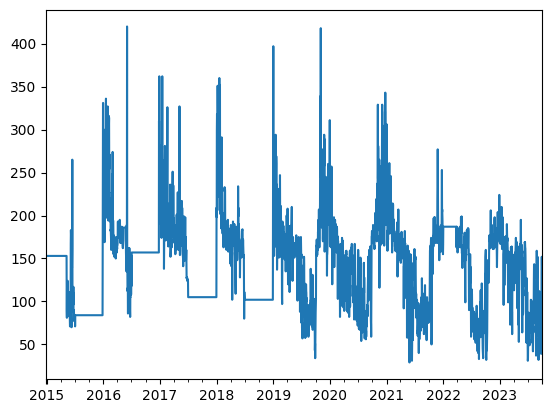

In [22]:
norm_aqi = new_data4['AQI']
norm_aqi.plot()

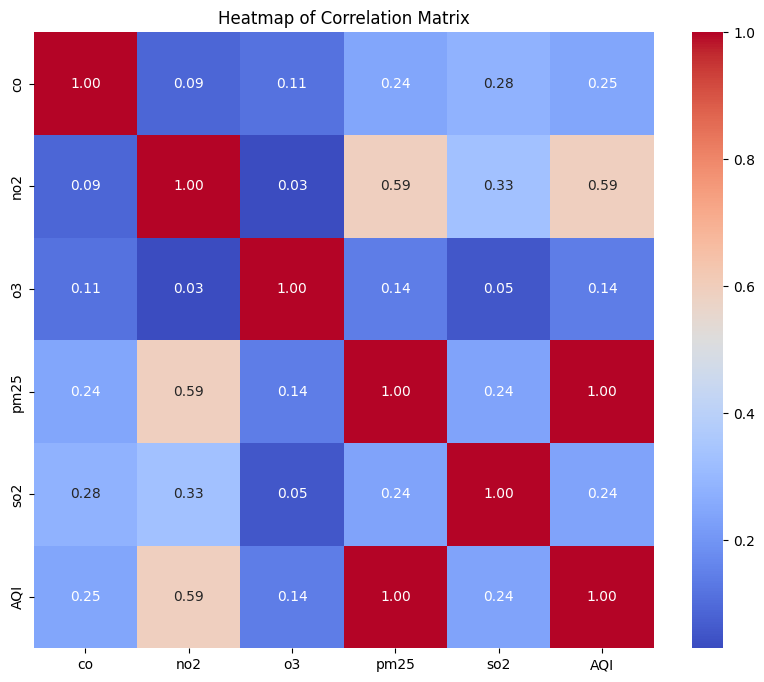

In [23]:
# Calculate the correlation matrix for numeric columns
corr = new_data4.corr(numeric_only=True)

# Create a heatmap using the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap of Correlation Matrix")
#file_name = "correlation_matrix.png"
#path = "/kaggle/working/"
#plt.savefig(path + file_name)
plt.show()

# 2. Machine Learning (without scaling)

## 2.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [24]:
new_data4.columns

Index(['co', 'no2', 'o3', 'pm25', 'so2', 'AQI'], dtype='object')

In [25]:
data = new_data4.copy()

In [26]:
data.head()

,co,no2,o3,pm25,so2,AQI
2014-12-29,18.9,0.8,13.238046,152.641704,3.3,153.0
2014-12-30,18.5,0.7,13.238046,152.641704,3.2,153.0
2014-12-31,0.2,2.3,13.238046,152.641704,3.2,153.0
2015-01-01,18.5,1.0,13.238046,152.641704,3.5,153.0
2015-01-02,18.5,1.2,13.238046,152.641704,3.6,153.0


In [27]:
num = data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
cat = data.select_dtypes(include=['object'])

print(num.columns)
print(cat.columns)

Index(['co', 'no2', 'o3', 'pm25', 'so2', 'AQI'], dtype='object')
Index([], dtype='object')


In [28]:
X = data[['co', 'no2', 'o3', 'pm25', 'so2']]

y = data['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2559, 5) (2559,) (640, 5) (640,)


In [29]:
# Preprocessor without scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['co', 'no2', 'o3', 'pm25', 'so2'])
    ])
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

## 2.2. ML Model

In [30]:
def compare_and_save_models(X_train, X_test, y_train, y_test, preprocessor, metric='mse', save_dir='models'):
    
    
    # Initialize models
    models = {
        'knn': KNeighborsRegressor(n_neighbors=2),
        'random_forest': RandomForestRegressor(),
        'xgboost': XGBRegressor(objective='reg:squarederror'),
        'svr' : SVR(kernel='linear'),
        'neural_network': MLPRegressor(hidden_layer_sizes=(8,), activation='relu', 
                                     solver='adam', max_iter=2000, 
                                     learning_rate_init=0.0005)
    }
    
    # Dictionary to store results
    results = {}
    
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Train and evaluate each model
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('regressor', model)])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'r2_train': r2_score(y_train, y_pred_train),
            'r2_test': r2_score(y_test, y_pred_test),
            'rmse_train': sqrt(mean_squared_error(y_train, y_pred_train)),
            'rmse_test': sqrt(mean_squared_error(y_test, y_pred_test)),
            'mae_train': mean_absolute_error(y_train, y_pred_train),
            'mae_test': mean_absolute_error(y_test, y_pred_test),
            'mse_train': mean_squared_error(y_train, y_pred_train),
            'mse_test': mean_squared_error(y_test, y_pred_test)
        }
        
        results[name] = {
            'pipeline': pipeline,
            'metrics': metrics
        }
    
    # Determine best model based on specified metric
    metric_map = {
        'r2': 'r2_test',
        'rmse': 'rmse_test',
        'mae': 'mae_test',
        'mse': 'mse_test'
    }
    
    comparison_metric = metric_map[metric]
    
    if metric == 'r2':  # Only R² should use max, all others should use min
        best_model = max(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    else:  # For MSE, RMSE, MAE - lower is better
        best_model = min(results.items(), 
                        key=lambda x: x[1]['metrics'][comparison_metric])
    
    # Save the best model
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(save_dir, 
                             f'best_model_{best_model[0]}_{timestamp}.joblib')
    joblib.dump(best_model[1]['pipeline'], model_path)
    
    # Prepare return dictionary
    return_dict = {
        'best_model': best_model[0],
        'best_model_path': model_path,
        'model_performances': {name: results[name]['metrics'] 
                             for name in results.keys()}
    }
    
    return return_dict

In [31]:
# Get the results first
results = compare_and_save_models(
    X_train, X_test, y_train, y_test,
    preprocessor,
    metric='mse',
    save_dir='models'
)

In [32]:
# Print detailed results for all models
print("\nDetailed Model Performance Summary:")
print("-" * 50)

for model_name, performance in results['model_performances'].items():
    print(f"\n{model_name.upper()} Results:")
    print(f"R² score (train): {performance['r2_train']:.4f}")
    print(f"R² score (test): {performance['r2_test']:.4f}")
    print(f"RMSE (train): {performance['rmse_train']:.4f}")
    print(f"RMSE (test): {performance['rmse_test']:.4f}")
    print(f"MAE (train): {performance['mae_train']:.4f}")
    print(f"MAE (test): {performance['mae_test']:.4f}")
    print(f"MSE (train): {performance['mse_train']:.4f}")
    print(f"MSE (test): {performance['mse_test']:.4f}")

print("\n" + "=" * 50)
print(f"Best Model: {results['best_model']}")
print(f"Model saved at: {results['best_model_path']}")


Detailed Model Performance Summary:
--------------------------------------------------

KNN Results:
R² score (train): 0.9998
R² score (test): 0.9993
RMSE (train): 0.7895
RMSE (test): 1.3887
MAE (train): 0.4574
MAE (test): 0.7852
MSE (train): 0.6234
MSE (test): 1.9285

RANDOM_FOREST Results:
R² score (train): 0.9999
R² score (test): 0.9998
RMSE (train): 0.5353
RMSE (test): 0.6354
MAE (train): 0.0426
MAE (test): 0.0714
MSE (train): 0.2865
MSE (test): 0.4038

XGBOOST Results:
R² score (train): 1.0000
R² score (test): 0.9975
RMSE (train): 0.1145
RMSE (test): 2.5887
MAE (train): 0.0632
MAE (test): 0.4062
MSE (train): 0.0131
MSE (test): 6.7015

SVR Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.0797
RMSE (test): 0.0850
MAE (train): 0.0629
MAE (test): 0.0648
MSE (train): 0.0063
MSE (test): 0.0072

NEURAL_NETWORK Results:
R² score (train): 1.0000
R² score (test): 1.0000
RMSE (train): 0.1922
RMSE (test): 0.1274
MAE (train): 0.0609
MAE (test): 0.0602
MSE (train): 0.0

# 3 - Deep Learning Model(Without Scaling)

## 3.1. Splitting & Preprocessing the Raw Data(Normal AQI)

In [33]:
aqi_normal = new_data4.copy()

In [34]:
aqi_normal.head()

,co,no2,o3,pm25,so2,AQI
2014-12-29,18.9,0.8,13.238046,152.641704,3.3,153.0
2014-12-30,18.5,0.7,13.238046,152.641704,3.2,153.0
2014-12-31,0.2,2.3,13.238046,152.641704,3.2,153.0
2015-01-01,18.5,1.0,13.238046,152.641704,3.5,153.0
2015-01-02,18.5,1.2,13.238046,152.641704,3.6,153.0


In [35]:
def new_data_to_X_y(new_data, window_size, train_pct, val_pct, test_pct):
    
    new_data_as_np = new_data.to_numpy()
    
    # Split features and target
    features = new_data_as_np[:, :-1]  # All columns except the last one
    target = new_data_as_np[:, -1]     # Only the AQI column
    
    # Split data based on percentages
    total_len = len(features)
    train_end = int(train_pct * total_len)
    val_end = train_end + int(val_pct * total_len)
    
    # Prepare train, val, and test splits for both features and target
    train_features = features[:train_end]
    train_target = target[:train_end]
    
    val_features = features[train_end:val_end]
    val_target = target[train_end:val_end]
    
    test_features = features[val_end:]
    test_target = target[val_end:]
    
    # Helper function to create X and y
    def create_X_y(feature_data, target_data):
        X, y = [], []
        for i in range(len(feature_data) - window_size):
            # Create sequence of all features
            sequence = feature_data[i:i + window_size]
            X.append(sequence)
            # Get the target AQI value
            y.append(target_data[i + window_size])
        return np.array(X), np.array(y)
    
    
    X_train, y_train = create_X_y(train_features, train_target)
    X_val, y_val = create_X_y(val_features, val_target)
    X_test, y_test = create_X_y(test_features, test_target)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [36]:
WINDOW_SIZE = 6
NUM_FEATURES = 6
train_pct = 0.8
val_pct = 0.1
test_pct = 0.1

(X_train1, y_train1), (X_val1, y_val1), (X_test1, y_test1) = new_data_to_X_y(
    aqi_normal, WINDOW_SIZE, train_pct, val_pct, test_pct
)

In [37]:
# shapes
print("Train shapes:", X_train1.shape, y_train1.shape)
print("Validation shapes:", X_val1.shape, y_val1.shape)
print("Test shapes:", X_test1.shape, y_test1.shape)

Train shapes: (2553, 6, 5) (2553,)
Validation shapes: (313, 6, 5) (313,)
Test shapes: (315, 6, 5) (315,)


##  3.2. DL Model

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

### LSTM(normal)

In [40]:
model5 = Sequential()
model5.add(InputLayer((6, 5)))  # 6 timestamps, 6 features
model5.add(LSTM(32, activation='relu', return_sequences=False))  # Single LSTM layer
model5.add(Dense(16, activation='relu')) 
model5.add(Dense(1, activation='linear'))  

cp5 = ModelCheckpoint('/kaggle/working/model5.keras', save_best_only=True)

model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), 
               metrics=[RootMeanSquaredError()])

model5.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, 
           callbacks=[cp5])

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 17934.8008 - root_mean_squared_error: 130.8164 - val_loss: 327.5775 - val_root_mean_squared_error: 18.0991
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 651.5836 - root_mean_squared_error: 25.5042 - val_loss: 264.8057 - val_root_mean_squared_error: 16.2729
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 608.2059 - root_mean_squared_error: 24.5658 - val_loss: 277.4465 - val_root_mean_squared_error: 16.6567
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 621.6763 - root_mean_squared_error: 24.9203 - val_loss: 247.6574 - val_root_mean_squared_error: 15.7371
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 668.5015 - root_mean_squared_error: 25.8191 - val_loss: 253.4038 - val_root_mean_squared_error: 15.9187
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 622.5438 - root_mean_squared_error: 24.9178 - val_loss: 222.2501 - val_root_mean_squared_error: 14.9081
Epoch 7/50
80/80 ━━━━━━━

In [41]:
from tensorflow.keras.models import load_model
model5 = load_model('/kaggle/working/model5.keras')

In [42]:
# Evaluate the model on the train data
train_result = model5.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 12.9444
Mean Squared Error (MSE): 530.2317
Root Mean Squared Error (RMSE): 23.0268
R-squared (Accuracy): 0.8101


In [43]:
# Evaluate the model on the validation data
val_result = model5.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 9.3205
Mean Squared Error (MSE): 203.1699
Root Mean Squared Error (RMSE): 14.2538
R-squared (Accuracy): 0.9222


In [44]:
# Evaluate the model on the test data
test_result = model5.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 15.8579
Mean Squared Error (MSE): 460.6264
Root Mean Squared Error (RMSE): 21.4622
R-squared (Accuracy): 0.7692


In [45]:
train_predictions = model5.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Train Predictions,Actuals
0,150.270477,153.0
1,149.686371,153.0
2,149.760254,153.0
3,150.719086,153.0
4,150.469147,153.0
...,...,...
2548,214.225937,207.0
2549,207.407318,198.0
2550,203.561081,193.0
2551,202.520828,163.0


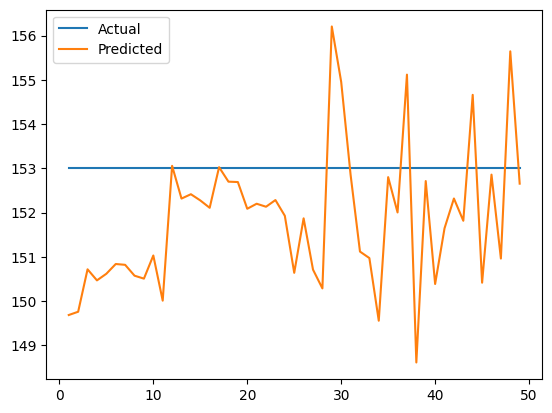

In [46]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [47]:
val_predictions = model5.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Train Predictions,Actuals
0,182.507034,187.0
1,185.358032,187.0
2,186.864731,187.0
3,186.864731,187.0
4,186.864731,187.0
...,...,...
308,169.424835,178.0
309,178.154724,189.0
310,182.550095,173.0
311,171.543610,164.0


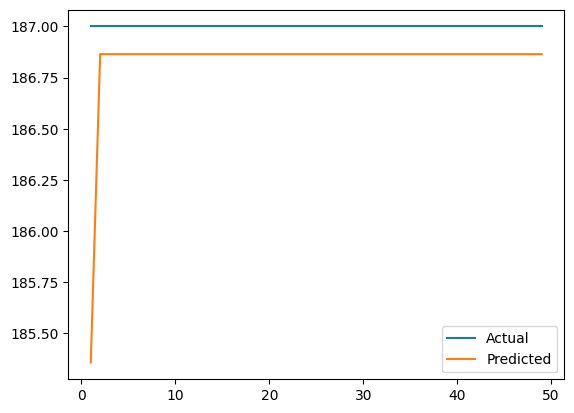

In [48]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [49]:
test_predictions = model5.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Train Predictions,Actuals
0,160.154419,162.0
1,160.171875,161.0
2,159.989716,163.0
3,162.497345,170.0
4,171.612671,178.0
...,...,...
310,62.414093,105.0
311,98.371414,134.0
312,121.886986,152.0
313,140.670578,139.0


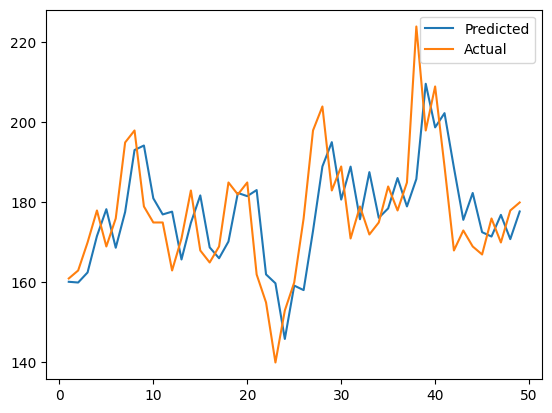

In [50]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

### Hybrid CNN + LSTM¶

In [51]:
model8 = Sequential()
model8.add(InputLayer((6, 5)))  # 6 timestamps, 6 features
model8.add(Conv1D(32, kernel_size=2, activation='relu'))  # 1D Convolutional Layer
model8.add(MaxPooling1D(pool_size=2))  # Max Pooling
model8.add(LSTM(64, activation='relu', return_sequences=False))  
model8.add(Dropout(0.3))  
model8.add(Dense(32, activation='relu'))  
model8.add(Dense(1, activation='linear'))  

cp8 = ModelCheckpoint('/kaggle/working/model8.keras', save_best_only=True)

model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), 
               metrics=[RootMeanSquaredError()])

model8.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, 
           callbacks=[cp8])

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 9653.7139 - root_mean_squared_error: 95.3825 - val_loss: 561.4880 - val_root_mean_squared_error: 23.6957
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1608.9008 - root_mean_squared_error: 40.0895 - val_loss: 511.1370 - val_root_mean_squared_error: 22.6083
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1523.6152 - root_mean_squared_error: 39.0072 - val_loss: 622.7626 - val_root_mean_squared_error: 24.9552
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1519.8585 - root_mean_squared_error: 38.9113 - val_loss: 599.4789 - val_root_mean_squared_error: 24.4843
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1310.5363 - root_mean_squared_error: 36.1645 - val_loss: 1080.6317 - val_root_mean_squared_error: 32.8730
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1147.2487 - root_mean_squared_error: 33.8549 - val_loss: 901.7563 - val_root_mean_squared_error: 30.0293
Epoch 7/50
80/80 ━━━

In [52]:
from tensorflow.keras.models import load_model
model8 = load_model('/kaggle/working/model8.keras')

In [53]:
# Evaluate the model on the train data
train_result = model8.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 19.1153
Mean Squared Error (MSE): 974.0379
Root Mean Squared Error (RMSE): 31.2096
R-squared (Accuracy): 0.6511


In [54]:
# Evaluate the model on the validation data
val_result = model8.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 16.2314
Mean Squared Error (MSE): 511.1370
Root Mean Squared Error (RMSE): 22.6083
R-squared (Accuracy): 0.8043


In [55]:
# Evaluate the model on the test data
test_result = model8.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 22.6932
Mean Squared Error (MSE): 877.6670
Root Mean Squared Error (RMSE): 29.6254
R-squared (Accuracy): 0.5602


In [56]:
train_predictions = model8.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Train Predictions,Actuals
0,147.633713,153.0
1,146.001648,153.0
2,148.077286,153.0
3,145.396072,153.0
4,145.246307,153.0
...,...,...
2548,202.016449,207.0
2549,196.610992,198.0
2550,212.764816,193.0
2551,206.285873,163.0


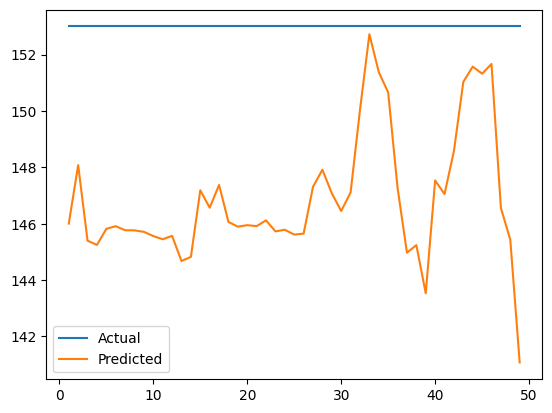

In [57]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [58]:
val_predictions = model8.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Train Predictions,Actuals
0,175.140366,187.0
1,177.133163,187.0
2,177.009125,187.0
3,177.009125,187.0
4,177.009125,187.0
...,...,...
308,162.780746,178.0
309,162.543793,189.0
310,163.197922,173.0
311,167.228271,164.0


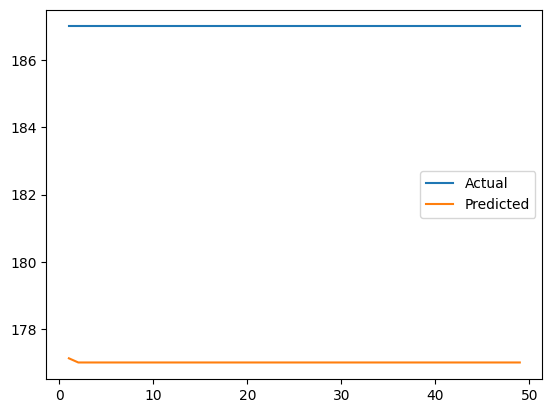

In [59]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [60]:
test_predictions = model8.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Train Predictions,Actuals
0,164.145813,162.0
1,161.244308,161.0
2,164.568069,163.0
3,155.162613,170.0
4,158.021576,178.0
...,...,...
310,52.169441,105.0
311,52.127663,134.0
312,68.097450,152.0
313,82.897705,139.0


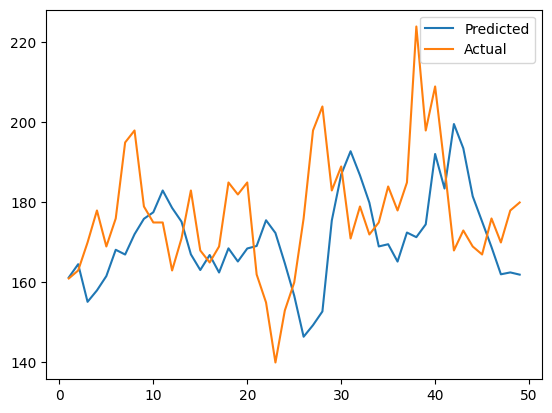

In [61]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

### Advanced Stacked GRU + Dense¶

In [62]:
model9 = Sequential()
model9.add(InputLayer((6, 5)))  # 6 timestamps, 6 features
model9.add(BatchNormalization())  # Normalize inputs
model9.add(GRU(128, activation='relu', return_sequences=True))  # GRU layer
model9.add(Dropout(0.3))  # Dropout for regularization
model9.add(GRU(64, activation='relu', return_sequences=False))  # Second GRU layer
model9.add(Dense(32, activation='relu'))  # Fully connected layer
model9.add(Dense(16, activation='relu'))  # Second dense layer
model9.add(Dense(1, activation='linear'))  # Output layer

cp9 = ModelCheckpoint('/kaggle/working/model9.keras', save_best_only=True)

model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), 
               metrics=[RootMeanSquaredError()])

model9.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, 
           callbacks=[cp9])

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 19353.3301 - root_mean_squared_error: 137.8744 - val_loss: 8971.4648 - val_root_mean_squared_error: 94.7178
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1734.1976 - root_mean_squared_error: 41.5881 - val_loss: 654.5659 - val_root_mean_squared_error: 25.5845
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1280.4598 - root_mean_squared_error: 35.7662 - val_loss: 625.4145 - val_root_mean_squared_error: 25.0083
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1285.4624 - root_mean_squared_error: 35.7174 - val_loss: 921.8225 - val_root_mean_squared_error: 30.3615
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1113.7137 - root_mean_squared_error: 33.3414 - val_loss: 577.9508 - val_root_mean_squared_error: 24.0406
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1018.5770 - root_mean_squared_error: 31.8866 - val_loss: 674.6611 - val_root_mean_squared_error: 25.9742
Epoch 7/50
80/80 

In [63]:
from tensorflow.keras.models import load_model
model9 = load_model('/kaggle/working/model9.keras')

In [64]:
# Evaluate the model on the train data
train_result = model9.predict(X_train1)

# Calculate metrics
mse = mean_squared_error(y_train1, train_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train1, train_result)
r2 = r2_score(y_train1, train_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 13.3787
Mean Squared Error (MSE): 487.4780
Root Mean Squared Error (RMSE): 22.0789
R-squared (Accuracy): 0.8254


In [65]:
# Evaluate the model on the validation data
val_result = model9.predict(X_val1)

# Calculate metrics
mse = mean_squared_error(y_val1, val_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val1, val_result)
r2 = r2_score(y_val1, val_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation Metrics:
Mean Absolute Error (MAE): 10.9033
Mean Squared Error (MSE): 264.0729
Root Mean Squared Error (RMSE): 16.2503
R-squared (Accuracy): 0.8989


In [66]:
# Evaluate the model on the test data
test_result = model9.predict(X_test1)

# Calculate metrics
mse = mean_squared_error(y_test1, test_result)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test1, test_result)
r2 = r2_score(y_test1, test_result)

# Print the results
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (Accuracy): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 17.0151
Mean Squared Error (MSE): 511.3740
Root Mean Squared Error (RMSE): 22.6136
R-squared (Accuracy): 0.7437


In [67]:
train_predictions = model9.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Train Predictions,Actuals
0,147.453232,153.0
1,145.820053,153.0
2,146.676849,153.0
3,147.582977,153.0
4,147.998016,153.0
...,...,...
2548,195.731674,207.0
2549,199.643311,198.0
2550,194.803589,193.0
2551,189.181335,163.0


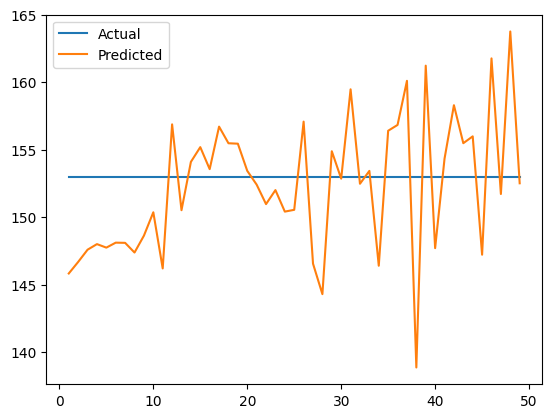

In [68]:
plt.plot(train_results['Actuals'][1:50], label='Actual')
plt.plot(train_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [69]:
val_predictions = model9.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val1})
val_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,185.588409,187.0
1,184.229248,187.0
2,184.926239,187.0
3,184.926239,187.0
4,184.926239,187.0
...,...,...
308,173.100708,178.0
309,176.558182,189.0
310,181.212097,173.0
311,173.821609,164.0


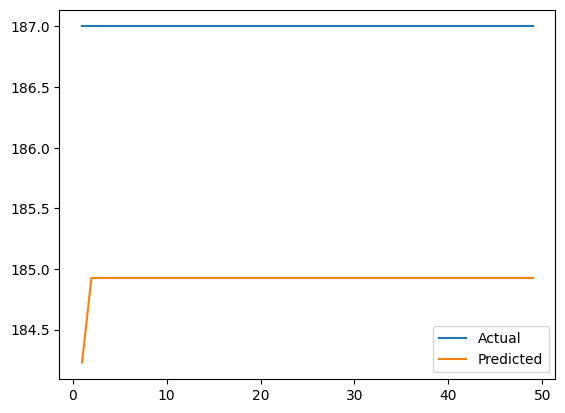

In [70]:
plt.plot(val_results['Actuals'][1:50], label='Actual')
plt.plot(val_results['Train Predictions'][1:50], label='Predicted')
plt.legend()
plt.show()

In [71]:
test_predictions = model9.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test1})
test_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Train Predictions,Actuals
0,156.090363,162.0
1,158.302795,161.0
2,161.675735,163.0
3,162.668549,170.0
4,171.787811,178.0
...,...,...
310,76.176239,105.0
311,100.463219,134.0
312,126.773148,152.0
313,141.423660,139.0


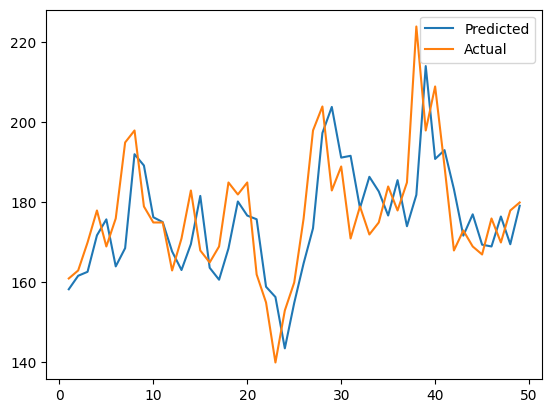

In [72]:
plt.plot(test_results['Train Predictions'][1:50], label='Predicted')
plt.plot(test_results['Actuals'][1:50], label='Actual')
plt.legend()
plt.show()

# 4. Load Model and export dataset

In [73]:
from joblib import load


# Load the model
model_path = '/kaggle/working/models/best_model_svr_20250128_152451.joblib'
model = load(model_path)

# Predict using the model
predictions = model.predict(data)

# Add predictions and location to the original DataFrame
data['Country_City'] = "India_Lucknow"
data['predictions'] = predictions

# Function to classify AQI levels
def classify_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

# Apply AQI bucket classification to the predictions column
data['AQI Bucket'] = data['AQI'].apply(classify_aqi)

# Save the updated DataFrame to CSV
os.makedirs('/kaggle/working', exist_ok=True)

# Save to CSV
data.to_csv('/kaggle/working/india_lucknow_predictions.csv')
